## ***`Assignment-4 :: Implement Custom RandomSearchCV with K-Folds CV on KNN`***

---
### ***`Contents`***

1. [Import dependent packages](#Packages_Import)
2. [Dataset creation](#Generating_Dataset)
    1. [Some Visualizations](#Some_plots)
3. [Assignment Task](#Task_to_accomplish)
    1. [Implementation of Custom RandomSearchCV](#Custom_RandomSearchCV)

#### **Packages_Import**

In [1]:
%matplotlib inline
import sys
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#### **Generating_Dataset**

In [2]:
## Creation of 2-Class classification dataset
X,y = make_classification(n_samples=10000,
                          n_features=2,
                          n_informative=2,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          random_state=50)

## Dataset division into TRAIN and TEST sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.33,random_state=42)

In [3]:
print(X.shape,y.shape)      ## Shape of entire dataset

(10000, 2) (10000,)


In [4]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)    ## Shape of Train and Test sets

(6700, 2) (6700,) (3300, 2) (3300,)


#### **Some_plots**

In [5]:
label_font = {'size':18, 'color':'coral', 'style':'italic', 'family':'calibri'}
title_font = {'size':22, 'color':'k', 'style':'oblique', 'family':'calibri'}

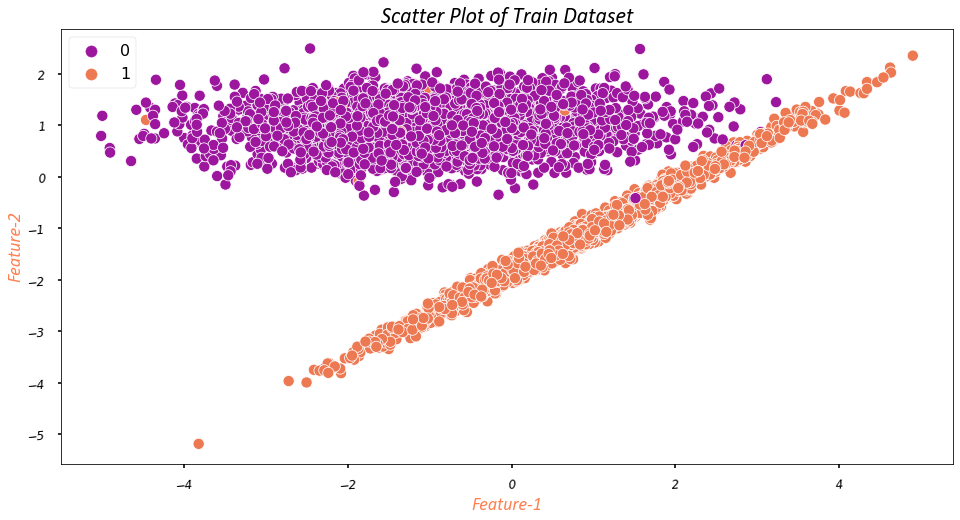

In [6]:
## Visualizing Train Dataset
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,8))
    fig = sns.scatterplot(X_train[:,0],X_train[:,1],palette='plasma',hue=y_train)
    plt.xlabel("Feature-1",fontdict=label_font)
    plt.ylabel("Feature-2",fontdict=label_font)
    plt.title("Scatter Plot of Train Dataset",fontdict=title_font)
    plt.xticks(rotation=5,style='oblique',size=12)
    plt.yticks(rotation=5,style='oblique',size=12)

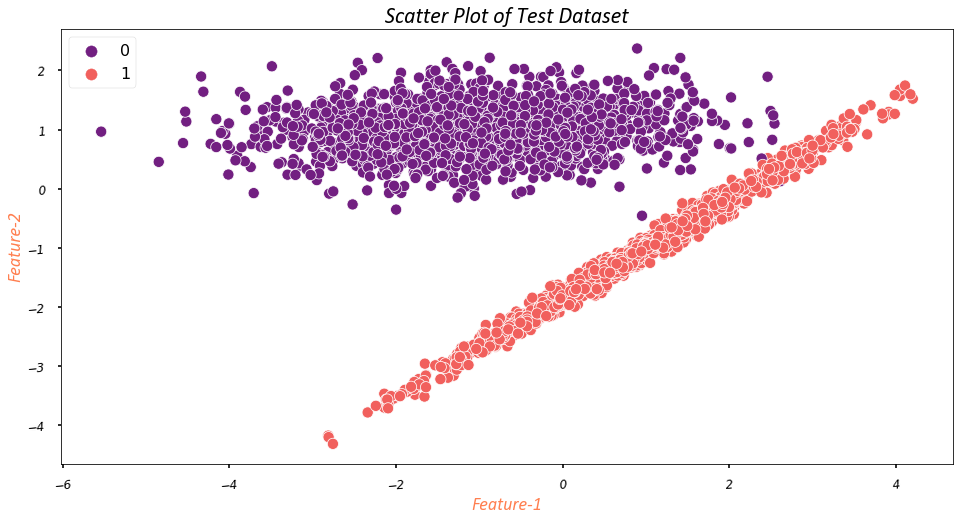

In [7]:
## Visualizing Test Dataset
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,8))
    fig = sns.scatterplot(X_test[:,0],X_test[:,1],palette='magma',hue=y_test)
    plt.xlabel("Feature-1",fontdict=label_font)
    plt.ylabel("Feature-2",fontdict=label_font)
    plt.title("Scatter Plot of Test Dataset",fontdict=title_font)
    plt.xticks(rotation=5,style='oblique',size=12)
    plt.yticks(rotation=5,style='oblique',size=12)

### **Some minute overlapping is visible in the above plots. But, overall both the classes are quite separable and occupied in their individual spaces.**

### **Task_to_accomplish**

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

## **`Custom_RandomSearchCV`**

In [8]:
def RandomSearchCV(X_train,y_train,clf,param_range,folds):
    """
    Description: This function is created for performing the RandomSearchCV of the classifier hyper-parameter.
    
    Input Parameters: It accepts below parameters:
        1. x_train: np.array
            Input features of shape, (n,d)
        2. y_train: np.array
            Target/Label of shape, (n,) or (n,1)
        3. classifier: its typically KNeighborsClassifier()
        4. param_range: tuple of int values
            Like (a,b) a < b   
            `Note: If a >= b then it will be set as (1,b).`
        5. folds: int
            Represents number of folds we need to devide the data and test our model
            
    Return:
        1. neighbors: list
            Containing values of hyper-parameter
        2. train_acc: list
            Model accuracy score on train data
        3. cv_acc: list
            Model accuracy score on test data
    """
    try:
        param_range[0] >= param_range[1]
    finally:
        param_range = (1, param_range[1])    # "Initialized the lower value of parameter range as 1."
    
    # Calculating the width of a set based on number of Folds and Input dataset size
    # And, generating the range of train and cv sets 
    cv_width = int(np.floor(len(X_train)/folds))
    lowest_val = 0
    max_val = int(len(X_train))
    cv_ranges = []
    for i in range(1,folds+1):
        if i == 1:
            cv_ranges.append((lowest_val, cv_width))
        elif i != folds:
            cv_ranges.append(((cv_width*(i-1)+1), cv_width*(i)))
        elif i == folds:
            cv_ranges.append(((cv_width*(i-1)+1), max_val))
    
    # Dividing the Input dataset into Train & CV sets based on the above calculated ranges
    train_set = []
    cv_set = []
    for i in range(0,folds):
        if i == 0:
            cnt = 1
            cv_set.append(cv_ranges[i])
            train_set.append(cv_ranges[cnt:])
            cnt += 1
        elif i > 0:
            cv_set.append(cv_ranges[i])
            lower_half = cv_ranges[0:i]
            upper_half = cv_ranges[cnt:]
            train_set.append(lower_half + upper_half)
            cnt +=1

    # Running the Classifier for the various values of hyper-parameter on different combinations of Train and CV sets
    k_vals = np.arange(param_range[0],param_range[1])
    neighs = np.sort(np.random.choice(k_vals,size=10,replace=False))
    
    neighbors = []
    train_acc = []
    cv_acc = []
    for k in tqdm(neighs):
        neighbors.append(k)
        taccs = []
        cv_accs = []
        for i in range(len(train_set)):
            X_train_set = np.array([[0,0]])
            X_cv_set = np.array([[0,0]])
            y_train_set = np.array([0])
            y_cv_set = np.array([0])
            for tup in train_set[i]:
                X_train_set = np.r_[X_train_set,X_train[tup[0]:tup[1]+1]]
                y_train_set = np.r_[y_train_set,y_train[tup[0]:tup[1]+1]]
            for indices in [cv_set[i]]:
                X_cv_set = np.r_[X_cv_set,X_train[indices[0]:indices[1]+1]]
                y_cv_set = np.r_[y_cv_set,y_train[indices[0]:indices[1]+1]]

            X_train_set = X_train_set[1:]
            y_train_set = y_train_set[1:]

            X_cv_set = X_cv_set[1:]
            y_cv_set = y_cv_set[1:]
            
            model = clf(n_neighbors=k)
            model.fit(X_train_set,y_train_set)
            taccs.append(model.score(X_train_set,y_train_set))            
            cv_accs.append(model.score(X_cv_set,y_cv_set))
        
        train_acc.append(np.mean(taccs))
        cv_acc.append(np.mean(cv_accs))
        
    return neighbors,train_acc,cv_acc

In [9]:
neighbors, train_accs, cv_accs = RandomSearchCV(X_train,y_train,KNeighborsClassifier,(51,25),3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]


### **For every value of K running the classifier for different combinations of TRAIN and CV set and generating their mean accuracy score.**
#### **Below are the resultant values:**

In [21]:
neighbors

[1, 3, 4, 9, 10, 13, 15, 18, 20, 23]

In [22]:
print(train_accs)

[1.0, 0.9936568221693625, 0.993432958278608, 0.992910559073918, 0.9929851970795904, 0.992537435880573, 0.9924628145836548, 0.9924628145836548, 0.9924628145836548, 0.9923881932867366]


In [23]:
len(train_accs)

10

In [24]:
print(cv_accs)

[0.9883582752566792, 0.9928362214967347, 0.9929854975080795, 0.9929855643281383, 0.9929855643281383, 0.9923885939228759, 0.9923885939228759, 0.9922393847315899, 0.9920901755403037, 0.9920901755403037]


In [25]:
len(cv_accs)

10

### **At n_neighbors 9, 10 and 15, the differences between the train and cv accuracies are minimum. But, going ahead with 9 because it is the point where the CV acc is maximum with the less with TRAIN scores.**

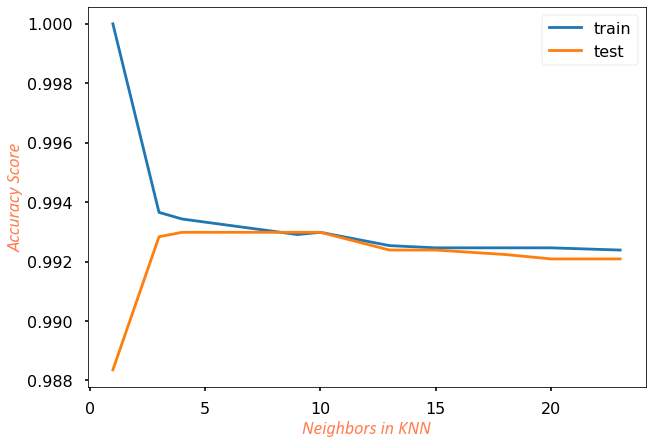

In [16]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(10,7))
    sns.lineplot(x=neighbors,y=train_accs,label='train')
    sns.lineplot(x=neighbors,y=cv_accs,label='test')
    plt.xlabel("Neighbors in KNN",fontdict=label_font)
    plt.ylabel("Accuracy Score",fontdict=label_font)

In [17]:
def plot_decision_boundary(X1, X2, y, clf):
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    with plt.style.context('seaborn-poster'):
        plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap='viridis',shading='auto')
        # Plot also the training points
        plt.scatter(X1, X2, c=y, cmap='gist_rainbow')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
        plt.show()

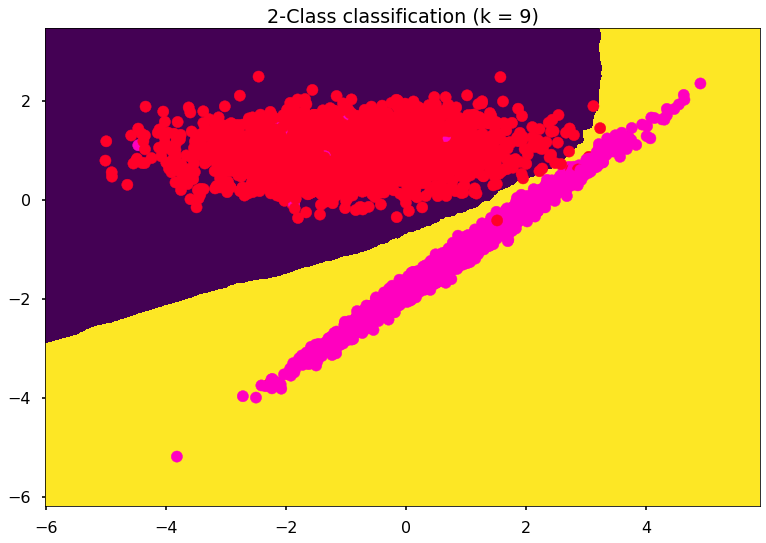

In [19]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 9)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)